In [220]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
from io import StringIO
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [14, 9] 

from speclib import plotting

%matplotlib inline

In [2]:
datapath = '../../allan_data/RGender_.dat'

# Load data

## Mend broken lines in file

Data file is in a borked format, where there's some answer-lines that spans multiple lines, even though not there's generally answers to one question pr. line.
This code attemps to merge the broken lines.
If there's no NaN's/null values in the loaded dataset, it's probably ok.

In [3]:
rx_is_sep_space = re.compile(r'(?<=") (?=")')
with open(datapath) as fid:
    keeplines = list()
    partial_list = list()
    for line in fid:
        str_chr_cnt = len((rx_is_sep_space.findall(line)))
        if str_chr_cnt > 9:
            if partial_list:
                keeplines.append(('\t'.join(partial_list)))
                partial_list = list()
            keeplines.append(line.strip())
        else:
            partial_list.append(line.strip()) 
        

In [9]:
df = pd.read_csv(StringIO('\n'.join(keeplines)), sep=r'(?<=\")\s+(?=\")', engine='python', header=0, index_col=0).T

Strip spaces from entries

In [10]:
df = df.applymap(lambda el: el.strip())

In [11]:
df.shape

(954, 1431)

In [12]:
df.isnull().any().any() 

False

Remove `"`-characters from data, and covert to ints where applicable

In [13]:
df = df.rename(columns=lambda s: s.strip('"').replace('.', '__'), index=lambda s: s.strip('"'))

for col in df.columns:
    df.loc[:, col] = df.loc[:, col].str.strip('"')
    rx_all_ints = re.compile(r'^-?\d+$')
    if df.loc[:, col].str.match(rx_all_ints).all():  # all integers
        as_int = df.loc[:, col].astype(int)
        df.loc[:, col] = as_int

-1 seems to indicate a non-answer. Replace with NaN's

In [14]:
df = df.replace(-1, np.NaN)
df = df.replace("-1", np.NaN)

In [15]:
null_ans = ~df.isnull() 

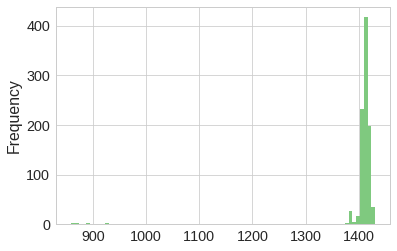

In [16]:
(null_ans.sum(axis=1)).plot.hist(80)

Users with non-null responses fewer that 1380 are discarded

In [17]:
discard_idx = ~null_ans.sum(axis=1) < 1380 

df = df[discard_idx]

Make boolean string indicators into booleans

In [80]:
str_bool_dict = {'FALSE': False, 'TRUE': True, np.NaN: np.NaN}
for col in df.columns:
    if df.loc[:, col].isin(['FALSE', 'TRUE', np.NaN]).all():  # all booleans
        df.loc[:, col] = df.loc[:, col].map(lambda el: str_bool_dict[el])

Translate the gender to english

In [81]:
str_gender_dict = {'Mand': 'male', 'Kvinde': 'female', np.NaN: np.NaN}
df.loc[:, 'gender'] = df.gender.map(lambda el: str_gender_dict[el])

## Examine column headers

In [82]:
pd.value_counts(el.rsplit('__')[-1] for el in df.columns if '__' in el) 

response       286
condition      286
question       286
answer         286
answer_type    286
dtype: int64

In [83]:
pd.value_counts(el.rsplit('__')[-1] for el in df.columns if '__'not  in el)

gender    1
dtype: int64

Seems like there's 5 attributes to each question... check that there is

In [84]:
df_cols = pd.DataFrame(el.rsplit('__') for el in df.columns if '__' in el)

In [85]:
df_cols.head(12) 

,0,1
0,function_duties,answer
1,function_duties,answer_type
2,function_duties,question
3,function_duties,response
4,function_duties,condition
5,narcissism_opponents,answer
6,narcissism_opponents,answer_type
7,narcissism_opponents,question
8,narcissism_opponents,response
9,narcissism_opponents,condition


In [86]:
df_cols.groupby(0).count()[1].value_counts()

5    286
Name: 1, dtype: int64

... and there is

### Examening data based on the answer_type columns

In [87]:
tmp = df.filter(like='_answer_type') 

tmprow = tmp.iloc[0, :]

tmprow.value_counts() 

radio           266
number           16
multi_number      2
scale             1
number;radio      1
Name: 0010fedde8e61cad5b049da6df8b5a, dtype: int64

#### Examening the `number;radio`  type

In [88]:
tmprow.where(tmprow == 'number;radio').dropna()

alcohol_debut__answer_type    number;radio
Name: 0010fedde8e61cad5b049da6df8b5a, dtype: object

In [89]:
tmplabel = tmprow.where(tmprow == 'number;radio').dropna().index[0].split('__')[0]
tmplabel

'alcohol_debut'

In [90]:
df_number_radio = df.filter(like=tmplabel)
df_number_radio.head() 

,alcohol_debut__answer,alcohol_debut__answer_type,alcohol_debut__question,alcohol_debut__response,alcohol_debut__condition
0010fedde8e61cad5b049da6df8b5a,1.0,number;radio,Hvor gammel var du første gang du drak mindst ...,15,False
002ee26a0c38a1f77b7cdeab8046cd,1.0,number;radio,Hvor gammel var du første gang du drak mindst ...,14,False
0037c93a19a7e90580086b462ba11b,1.0,number;radio,Hvor gammel var du første gang du drak mindst ...,15,False
005b1e0298bde6b726156aefb8d88c,1.0,number;radio,Hvor gammel var du første gang du drak mindst ...,14,False
00ad591e46eb6f3d8c474d9de9e219,1.0,number;radio,Hvor gammel var du første gang du drak mindst ...,16,False


In [91]:
for col in (df_number_radio[col] for col in df_number_radio.columns):
    print(col.value_counts().sort_index(), end='\n'*3)

0.0     34
1.0    906
Name: alcohol_debut__answer, dtype: int64


number;radio    954
Name: alcohol_debut__answer_type, dtype: int64


Hvor gammel var du første gang du drak mindst en genstand?    954
Name: alcohol_debut__question, dtype: int64


10                                 13
11                                  9
12                                 43
13                                151
14                                219
15                                272
16                                121
17                                 30
18                                 18
19                                  7
20                                  2
21                                  1
22                                  1
29                                  1
5                                   8
6                                   1
7                                   1
8                                   5
9                                   3
jeg_har_aldrig_drukket_alkohol 

The `number;radio` type seems to a radio-button with numbers on a numerical scale

#### Examening the `number` answer type

In [95]:
tmprow.where(tmprow == 'number').dropna() 

alcohol_volume_sunday__answer_type       number
alcohol_volume_thursday__answer_type     number
alcohol_volume_saturday__answer_type     number
alcohol_volume_monday__answer_type       number
alcohol_volume_tuesday__answer_type      number
weight__answer_type                      number
alcohol_volume_wednesday__answer_type    number
smoke_volume_cerut__answer_type          number
function_activity__answer_type           number
height__answer_type                      number
birthyear__answer_type                   number
smoke_volume_cigar__answer_type          number
smoke_volume_pibe__answer_type           number
alcohol_volume_friday__answer_type       number
smoke_volume_cigarette__answer_type      number
know_other_number__answer_type           number
Name: 0010fedde8e61cad5b049da6df8b5a, dtype: object

In [100]:
tmplabel = tmprow.where(tmprow == 'number').dropna().index.str.replace('__answer_type', '')
tmplabel

Index(['alcohol_volume_sunday', 'alcohol_volume_thursday',
       'alcohol_volume_saturday', 'alcohol_volume_monday',
       'alcohol_volume_tuesday', 'weight', 'alcohol_volume_wednesday',
       'smoke_volume_cerut', 'function_activity', 'height', 'birthyear',
       'smoke_volume_cigar', 'smoke_volume_pibe', 'alcohol_volume_friday',
       'smoke_volume_cigarette', 'know_other_number'],
      dtype='object')

In [105]:
df_number = df.filter(regex='|'.join(tmplabel))

df_number.head()

,alcohol_volume_sunday__answer,alcohol_volume_sunday__answer_type,alcohol_volume_sunday__question,alcohol_volume_sunday__response,alcohol_volume_sunday__condition,alcohol_volume_thursday__answer,alcohol_volume_thursday__answer_type,alcohol_volume_thursday__question,alcohol_volume_thursday__response,alcohol_volume_thursday__condition,...,smoke_volume_cigarette__answer,smoke_volume_cigarette__answer_type,smoke_volume_cigarette__question,smoke_volume_cigarette__response,smoke_volume_cigarette__condition,know_other_number__answer,know_other_number__answer_type,know_other_number__question,know_other_number__response,know_other_number__condition
0010fedde8e61cad5b049da6df8b5a,0.0,number,,0.0,False,0.0,number,,0.0,False,...,NaN,number,,NaN,"smoke_freq=='Ja, dagligt'",15.0,number,Hvor mange?,15.0,know_other=='ja'
002ee26a0c38a1f77b7cdeab8046cd,0.0,number,,0.0,False,0.0,number,,0.0,False,...,20.0,number,,20.0,"smoke_freq=='Ja, dagligt'",NaN,number,Hvor mange?,NaN,know_other=='ja'
0037c93a19a7e90580086b462ba11b,0.0,number,,0.0,False,0.0,number,,0.0,False,...,NaN,number,,NaN,"smoke_freq=='Ja, dagligt'",2.0,number,Hvor mange?,2.0,know_other=='ja'
005b1e0298bde6b726156aefb8d88c,1.0,number,,1.0,False,0.0,number,,0.0,False,...,NaN,number,,NaN,"smoke_freq=='Ja, dagligt'",10.0,number,Hvor mange?,10.0,know_other=='ja'
00ad591e46eb6f3d8c474d9de9e219,0.0,number,,0.0,False,0.0,number,,0.0,False,...,NaN,number,,NaN,"smoke_freq=='Ja, dagligt'",NaN,number,Hvor mange?,NaN,know_other=='ja'


There's a lot of dimmensions in the count, so the plot are useful for showing the values are centered around a few variables for most answers.

/lscr_paper/allan/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/indexes/api.py:71: RuntimeWarning: '<' not supported between instances of 'float' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)
/lscr_paper/allan/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:5441: RuntimeWarning: '<' not supported between instances of 'float' and 'str', sort order is undefined for incomparable objects
  index = _union_indexes(indexes)
/lscr_paper/allan/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/indexes/api.py:71: RuntimeWarning: '>' not supported between instances of 'str' and 'float', sort order is undefined for incomparable objects
  result = result.union(other)


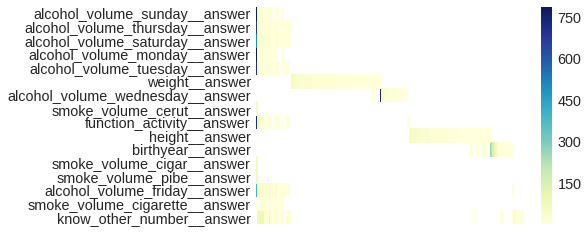

In [134]:
_ = df_number.filter(regex='__answer$').apply(pd.value_counts)
ax = sns.heatmap(_.T, xticklabels=False, cmap='YlGnBu')


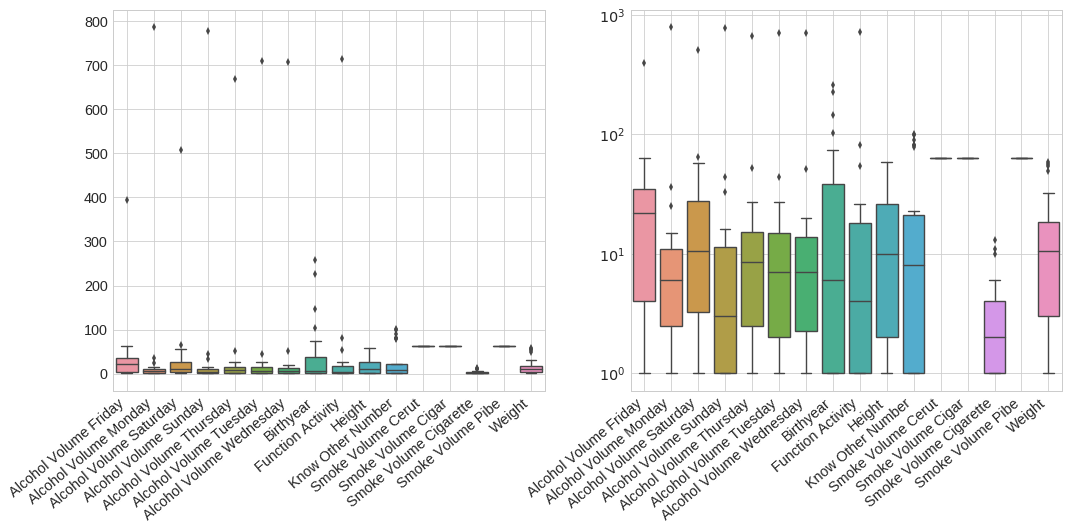

In [222]:
fig, (ax0, ax1) = plotting.boxplot_dataframe_columns(df_number)

Next, clean responses like
```

014813ebd3e875e031adf6ab717acc       Passer slet ikke 1
0149cde16952c52bd38550ba4e5c56                        4
0192d71b149f60e98272b3ad3daf05                        2
01b55a9e2a33743a3b956085974184                        3
01b752d455e97e5dd2262d339f2187       Passer slet ikke 1
01b913754e34bbac2a17afbc398702    6 Passer fuldstændigt
01bead0797b27df58534edb513d875                        4
```

Test that the regex works

In [111]:
rx_stupid_format = re.compile(r'^(?:\D+\d+)|(?:\d+\D+)$')
tmp = pd.Series(['foo 123', '456 bar', 'biz', '789', 987])
tmp.str.match(rx_stupid_format)

0     True
1     True
2    False
3    False
4      NaN
dtype: object

In [112]:
df_is_stupid_format = df.copy()
for col in df.columns:
    try:
        df_is_stupid_format[col] = df[col].str.match(rx_stupid_format)
    except AttributeError:
        df_is_stupid_format[col] = np.NaN

In [113]:
df_is_stupid_format.head(15)

,function_duties__answer,function_duties__answer_type,function_duties__question,function_duties__response,function_duties__condition,narcissism_opponents__answer,narcissism_opponents__answer_type,narcissism_opponents__question,narcissism_opponents__response,narcissism_opponents__condition,...,selfesteem_proud__answer_type,selfesteem_proud__question,selfesteem_proud__response,selfesteem_proud__condition,narcissism_excellent__answer,narcissism_excellent__answer_type,narcissism_excellent__question,narcissism_excellent__response,narcissism_excellent__condition,gender
0010fedde8e61cad5b049da6df8b5a,NaN,False,False,False,False,NaN,False,False,False,False,...,False,False,False,False,NaN,False,False,False,False,False
002ee26a0c38a1f77b7cdeab8046cd,NaN,False,False,False,False,NaN,False,False,False,False,...,False,False,False,False,NaN,False,False,False,False,False
0037c93a19a7e90580086b462ba11b,NaN,False,False,False,False,NaN,False,False,False,False,...,False,False,False,False,NaN,False,False,False,False,False
005b1e0298bde6b726156aefb8d88c,NaN,False,False,False,False,NaN,False,False,False,False,...,False,False,False,False,NaN,False,False,False,False,False
00ad591e46eb6f3d8c474d9de9e219,NaN,False,False,False,False,NaN,False,False,False,False,...,False,False,False,False,NaN,False,False,True,False,False
00b602879b6f7d7e1d4223325e0cb2,NaN,False,False,False,False,NaN,False,False,False,False,...,False,False,False,False,NaN,False,False,False,False,False
00f189f7091248c825f8dda0bc9d49,NaN,False,False,False,False,NaN,False,False,False,False,...,False,False,False,False,NaN,False,False,False,False,False
0110f75c4a9998776f39d0ce7e5393,NaN,False,False,False,False,NaN,False,False,False,False,...,False,False,False,False,NaN,False,False,False,False,False
012a5e138f69d2f344b9dceb7363e5,NaN,False,False,False,False,NaN,False,False,False,False,...,False,False,False,False,NaN,False,False,True,False,False
01384258ba14c9f69775c93d5f37f7,NaN,False,False,False,False,NaN,False,False,False,False,...,False,False,False,False,NaN,False,False,False,False,False


In [114]:
df_is_stupid_format.shape

(954, 1431)

In [115]:
df_is_stupid_format = df_is_stupid_format.dropna(axis=1, how='all')

In [116]:
df_is_stupid_format.shape

(954, 1136)

In [117]:
stupid_format_idx = df_is_stupid_format.any()[df_is_stupid_format.any()].index

In [121]:
tmp = df.loc[:, stupid_format_idx]

In [123]:
tmp.head() 

,narcissism_opponents__response,alcohol_binge5__question,alcohol_binge5__response,alcohol_volume_saturday__response,alcohol_very_drunk__response,narcissism_critisism__response,panas_attention__response,panas_hostile__response,sleep_time_wake__question,medicine_headache__response,...,give_money__question,give_money__response,narcissism_competitor__response,narcissism_irritation__response,politic_poverty__question,alcohol_weekend__response,medicine_sleep__response,panas_afraid__response,alcohol_everyday__response,narcissism_excellent__response
0010fedde8e61cad5b049da6df8b5a,2,Drukket mere end 5 genstande på en dag/aften,2 gange,0,1 gange,2,2,aldrig 1,Hvornår vågner du normalt om morgenen på hverd...,"Nej, slet ikke",...,"Forestil dig, at vi gav dig 100 kroner. Du har...",DKK 50,Passer slet ikke 1,2,Nu bedes du svare på en skala fra 1 til 5. Nog...,3 gange,"Nej, slet ikke",aldrig 1,0 gange,4
002ee26a0c38a1f77b7cdeab8046cd,3,Drukket mere end 5 genstande på en dag/aften,0 gange,0,0 gange,3,3,2,Hvornår vågner du normalt om morgenen på hverd...,"Nej, slet ikke",...,"Forestil dig, at vi gav dig 100 kroner. Du har...",DKK 25,2,2,Nu bedes du svare på en skala fra 1 til 5. Nog...,1 gange,"Nej, slet ikke",aldrig 1,0 gange,3
0037c93a19a7e90580086b462ba11b,2,Drukket mere end 5 genstande på en dag/aften,2 gange,2,2 gange,2,3,aldrig 1,Hvornår vågner du normalt om morgenen på hverd...,"Nej, slet ikke",...,"Forestil dig, at vi gav dig 100 kroner. Du har...",DKK 0,2,2,Nu bedes du svare på en skala fra 1 til 5. Nog...,3 gange,"Nej, slet ikke",aldrig 1,0 gange,2
005b1e0298bde6b726156aefb8d88c,3,Drukket mere end 5 genstande på en dag/aften,1 gange,1,1 gange,3,3,aldrig 1,Hvornår vågner du normalt om morgenen på hverd...,"Nej, slet ikke",...,"Forestil dig, at vi gav dig 100 kroner. Du har...",DKK 25,2,Passer slet ikke 1,Nu bedes du svare på en skala fra 1 til 5. Nog...,1 gange,"Nej, slet ikke",aldrig 1,0 gange,2
00ad591e46eb6f3d8c474d9de9e219,2,Drukket mere end 5 genstande på en dag/aften,1 gange,0,0 gange,Passer slet ikke 1,4 altid,aldrig 1,Hvornår vågner du normalt om morgenen på hverd...,"Ja, 1 gang om ugen",...,"Forestil dig, at vi gav dig 100 kroner. Du har...",DKK 0,Passer slet ikke 1,Passer slet ikke 1,Nu bedes du svare på en skala fra 1 til 5. Nog...,1 gange,"Nej, slet ikke",aldrig 1,0 gange,Passer slet ikke 1


In [ ]:
df.filter

In [141]:
df.filter(regex='answer|response')

,function_duties__answer,function_duties__answer_type,function_duties__response,narcissism_opponents__answer,narcissism_opponents__answer_type,narcissism_opponents__response,locus_of_control_13__answer,locus_of_control_13__answer_type,locus_of_control_13__response,locus_of_control_12__answer,...,bfi_forgive__response,bfi_calm__answer,bfi_calm__answer_type,bfi_calm__response,selfesteem_proud__answer,selfesteem_proud__answer_type,selfesteem_proud__response,narcissism_excellent__answer,narcissism_excellent__answer_type,narcissism_excellent__response
0010fedde8e61cad5b049da6df8b5a,0.0,radio,Slet ikke,1.0,radio,2,0.0,radio,"Hvad der sker for mig, skyldes det jeg selv gør",0.0,...,Enig,3.0,radio,Enig,2.0,radio,Uenig,3.0,radio,4
002ee26a0c38a1f77b7cdeab8046cd,1.0,radio,Lidt,2.0,radio,3,0.0,radio,"Hvad der sker for mig, skyldes det jeg selv gør",0.0,...,Hverken enig eller uenig,3.0,radio,Enig,2.0,radio,Uenig,2.0,radio,3
0037c93a19a7e90580086b462ba11b,1.0,radio,Lidt,1.0,radio,2,0.0,radio,"Hvad der sker for mig, skyldes det jeg selv gør",0.0,...,Enig,3.0,radio,Enig,1.0,radio,Enig,1.0,radio,2
005b1e0298bde6b726156aefb8d88c,1.0,radio,Lidt,2.0,radio,3,0.0,radio,"Hvad der sker for mig, skyldes det jeg selv gør",1.0,...,Enig,3.0,radio,Enig,2.0,radio,Uenig,1.0,radio,2
00ad591e46eb6f3d8c474d9de9e219,1.0,radio,Lidt,1.0,radio,2,0.0,radio,"Hvad der sker for mig, skyldes det jeg selv gør",0.0,...,Hverken enig eller uenig,2.0,radio,Hverken enig eller uenig,3.0,radio,Stærkt uenig,0.0,radio,Passer slet ikke 1
00b602879b6f7d7e1d4223325e0cb2,0.0,radio,Slet ikke,3.0,radio,4,0.0,radio,"Hvad der sker for mig, skyldes det jeg selv gør",0.0,...,Enig,3.0,radio,Enig,3.0,radio,Stærkt uenig,1.0,radio,2
00f189f7091248c825f8dda0bc9d49,1.0,radio,Lidt,1.0,radio,2,1.0,radio,"Nogen gange føler jeg, at jeg ikke har nok kon...",0.0,...,Uenig,2.0,radio,Hverken enig eller uenig,2.0,radio,Uenig,2.0,radio,3
0110f75c4a9998776f39d0ce7e5393,1.0,radio,Lidt,4.0,radio,5,0.0,radio,"Hvad der sker for mig, skyldes det jeg selv gør",0.0,...,Uenig,3.0,radio,Enig,1.0,radio,Enig,1.0,radio,2
012a5e138f69d2f344b9dceb7363e5,2.0,radio,Noget,2.0,radio,3,0.0,radio,"Hvad der sker for mig, skyldes det jeg selv gør",0.0,...,Enig,3.0,radio,Enig,3.0,radio,Stærkt uenig,0.0,radio,Passer slet ikke 1
01384258ba14c9f69775c93d5f37f7,0.0,radio,Slet ikke,1.0,radio,2,0.0,radio,"Hvad der sker for mig, skyldes det jeg selv gør",0.0,...,Enig,2.0,radio,Hverken enig eller uenig,2.0,radio,Uenig,2.0,radio,3
